In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
from scipy.signal import bessel, sosfiltfilt

from sklearn.neighbors import KernelDensity
from data_manager import DataManager
import transport_signal_processing as tsp

In [4]:
def normalized_histogram(cores, num_bins, limits):
    # compute normalized histograms
    h_l = []
    for c in tqdm(cores):
        n, x = np.histogram(c, bins=num_bins, range=limits)
        h_l.append(n / np.sum(n))

    # compute mean noramlized histogram
    h = np.mean(np.array(h_l), axis=0)
    xc = 0.5*(x[:-1] + x[1:])
    #dx = x[1] - x[0]
    
    return h, xc

In [6]:
# parameters
# voltages: 80, 100, 120, 150, 170, 190
path = "*"
re_sel = "AA00300AA"
key = "voltage"
level = 1
selected_only = True

# setup database connector
sigman = DataManager('database')

# load segments informations
sinfo_l = sigman.load_info(path, 's*')

# convert info to dataframe
df = pd.DataFrame(sinfo_l)

# keep only selected polymers in dataframe and signal info
df = df[df['analyte'].str.match(re_sel) & (df['selected'] > (level-1))]
sinfo_l = [sinfo_l[i] for i in df.index.values]
df = df.reset_index(drop=True)

# debug print
key_names = np.unique(df[key].values)
key_names = np.array(sorted(key_names.astype(int))).astype(np.str)  # numerical value only
print(key_names.shape[0], list(key_names))

# check
#assert len(polymer_names) == 1

3 ['80', '100', '120']


In [7]:
# parameters
limits = [-5.0, 20.0]
num_bins = 100

# batch compute average noramlized histograms
h_l = []
for vkey in key_names:
    # get segments information
    sinfo_l = df[df[key] == vkey].to_dict("records")
    
    # load events core
    cores = tsp.utils.load_core_events(sigman, sinfo_l, selected_only=True)

    # compute histogram
    h, xc = normalized_histogram(cores, num_bins, limits)
    
    # save results
    h_l.append(h)

100%|██████████| 28562/28562 [00:02<00:00, 13535.53it/s]


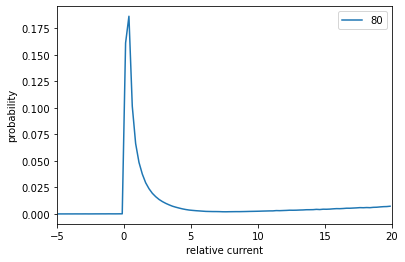

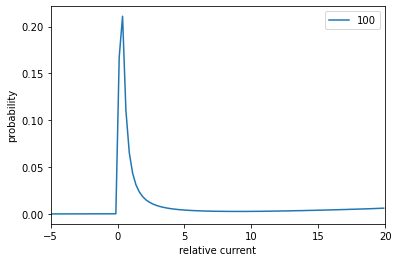

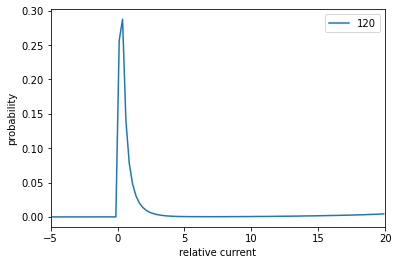

In [8]:
# plot
for i in range(len(h_l)):
    plt.figure()
    plt.plot(xc, h_l[i], '-', label=key_names[i])
    plt.xlim(limits)
    plt.legend(loc='best')
    plt.xlabel("relative current")
    plt.ylabel("probability")
    plt.show()

In [49]:
def steps_detection(I, ws=3, n_iters=8):
    # envelope iterative smoothing
    Is = I.copy()
    for k in range(n_iters):
        Imax, Imin = tsp.signals.envelope(Is, ws)
        Is = 0.5*(Imax + Imin)

    # steps location
    ids_step = np.where(np.abs(np.diff(np.sign(np.diff(Is)))) > 0.5)[0]

    # steps amplitudes
    dI = np.abs(np.diff(Is[ids_step]))
    
    return Is, ids_step, dI

i = 13218
dI_thr = 0.18088
num_levels = 4


/home/lfkrapp/anaconda3/envs/tsp/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


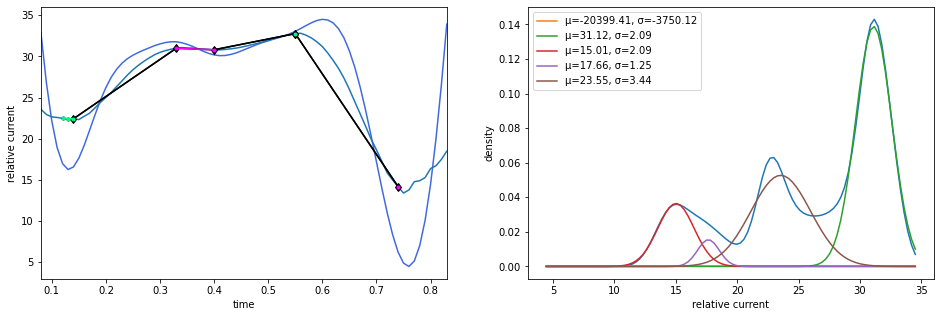

In [53]:
# parameters
bandwidth = 1.0
N = 100
max_num_gauss = 5
threshold = 0.1

# random choice
i = np.random.choice(len(cores))
i = 13218
print("i = {}".format(i))

# step detection
core = cores[i]
t = core[:,0]
I = core[:,1]
Is, ids_step, dI = steps_detection(I, ws=3, n_iters=4)

# large step detection
#dI_thr = np.mean(dI) + 2.0 * np.std(dI)
#dI_thr = np.percentile(dI, 95.0)
num_levels = np.sum(np.diff(np.sort(dI)) > 0.3)
#if num_levels == 0:
#    continue
dI_thr = np.sort(dI)[-(num_levels+1):][0]+1e-6
print("dI_thr = {:.5f}".format(dI_thr))

# selected steps
ids_sel = np.where(np.abs(dI) > dI_thr)[0]

# segmentation using selected steps
ids_segs = np.stack([np.concatenate([[0],ids_sel+1]), np.concatenate([ids_sel,[ids_step.shape[0]]])], axis=1)
Is_segs = [Is[ids_step[i:j+1]] for i,j in ids_segs]
I_segs = [I[ids_step[i:j+1]] for i,j in ids_segs]

# debug print
print("num_levels = {}".format(len(I_segs)))

# plot
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(t, I, '-', color='royalblue')
plt.plot(t, Is, '-')
plt.plot(t[ids_step], Is[ids_step], 'k.-')
for i in ids_sel:
    t_steps = t[ids_step]
    I_steps = Is[ids_step]
    plt.plot([t_steps[i],t_steps[i+1]], [I_steps[i], I_steps[i+1]], 'kd-')

for k,(i,j) in enumerate(ids_segs):
    ids = ids_step[i:j+1]
    plt.plot(t[ids], Is[ids], '.-', color=['springgreen','magenta'][k%2])

plt.xlim(t[0], t[-1])
plt.xlabel('time')
plt.ylabel('relative current')

# KDE
kde = KernelDensity(bandwidth=bandwidth)
kde.fit(Is.reshape(-1,1))
x = np.linspace(np.min(I), np.max(I), N)
y = np.exp(kde.score_samples(x.reshape(-1,1))).ravel()

# compute integral
s0 = np.sum(y)
mu_guess = x[np.argmax(y)]

# perform iterative gaussian fits until only "thr" of the distribution is unexplained
for k in range(max_num_gauss):
    z, popt = tsp.fits.multi_gauss_dist_fit(x, y, num_gauss=k+1, mu_guess=mu_guess)

    # compute residual error
    s = np.sum(np.abs(y - z))
    r = s/s0

    # pack results
    popt_l = [popt[3*k:3*(k+1)] for k in range(k+1)]

    # evaluate result
    if r < threshold:
        break

plt.subplot(122)
plt.plot(x,y)
for i in range(len(popt_l)):
    popt = popt_l[i]
    z = tsp.fits.gauss(x, popt[0], popt[1], popt[2])
    plt.plot(x,z,label="μ={:.2f}, σ={:.2f}".format(popt[1], popt[2]))
plt.xlabel('relative current')
plt.ylabel('density')
plt.legend(loc='best')
plt.show()

i = 10465


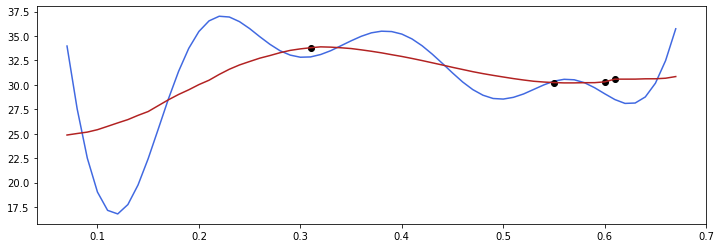

In [54]:
# random choice
i = np.random.choice(len(cores))
print("i = {}".format(i))
i = 432

# step detection
core = cores[i]
t = core[:,0]
I = core[:,1]
Is, ids_step, dI = steps_detection(I, ws=3, n_iters=8)

# plot
plt.figure(figsize=(12,4))
plt.plot(t, I, '-', color='royalblue')
plt.plot(t[ids_step], Is[ids_step], 'ko')
plt.plot(t, Is, '-', color='firebrick')
plt.show()

In [55]:
def steps_detection_spectrum(I, ws=5, n_order=10):
    # results variables
    Is_l, ids_step_l = [], []
    
    # envelope iterative smoothing
    Is = I.copy()
    for k in range(2**n_order):
        Imax, Imin = tsp.signals.envelope(Is, ws)
        Is = 0.5*(Imax + Imin)

        # if order reached
        if ((np.log2(k+1) - np.ceil(np.log2(k+1))) == 0):
            # steps location
            ids_step = np.where(np.abs(np.diff(np.sign(np.diff(Is)))) > 0.5)[0]
            
            # store results
            Is_l.append(Is.copy())
            ids_step_l.append(ids_step.copy())
    
    return Is_l, ids_step_l

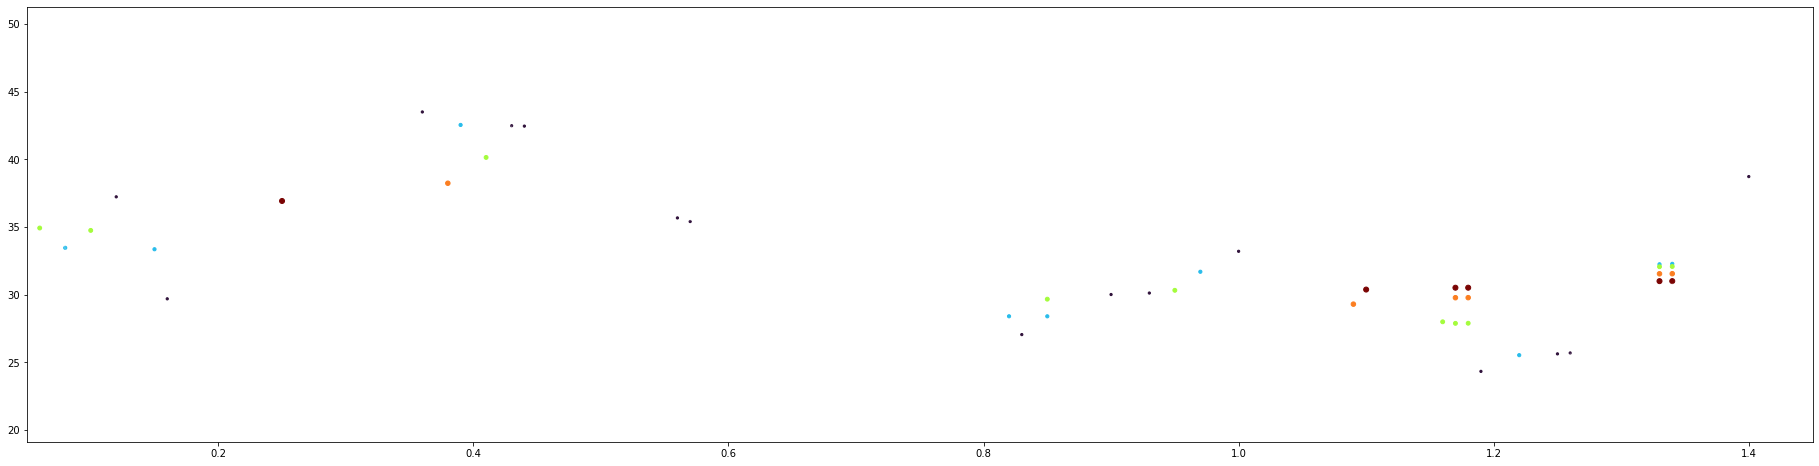

In [56]:
for _ in range(1):
    # random choice
    i = np.random.choice(len(cores))
    
    # step detection
    core = cores[i]
    t = core[:,0]
    I = core[:,1]
    Is_l, ids_step_l = steps_detection_spectrum(I, ws=8, n_order=10)

    # extract orders
    orders_l = []
    Ik_l = []
    tk_l = []
    for k in range(len(Is_l)):
        orders_l.append((k+1) * np.ones(len(ids_step_l[k])))
        Ik_l.append(Is_l[k][ids_step_l[k]])
        tk_l.append(t[ids_step_l[k]])

    # pack data
    o = np.concatenate(orders_l)
    Ik = np.concatenate(Ik_l)
    tk = np.concatenate(tk_l)

    # plot
    fig = plt.figure(figsize=(32,8))
    fig.patch.set_alpha(0.0)
    ax = fig.add_subplot(111)
    ax.patch.set_alpha(0.0)
    plt.plot(t, I, 'w-', alpha=0.2)
    plt.scatter(tk, Ik, s=5*o, c=o, cmap='turbo')
    plt.xlim(t[0], t[-1])
    plt.show()

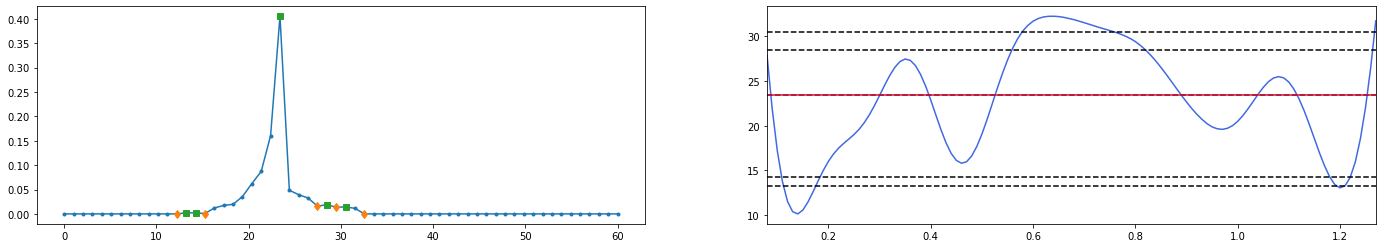

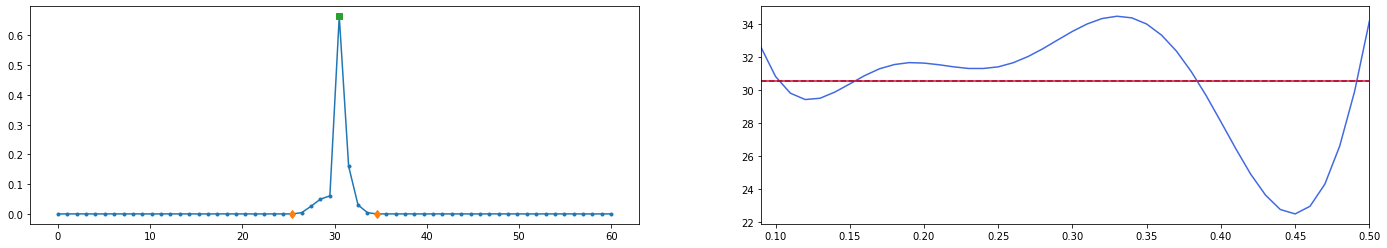

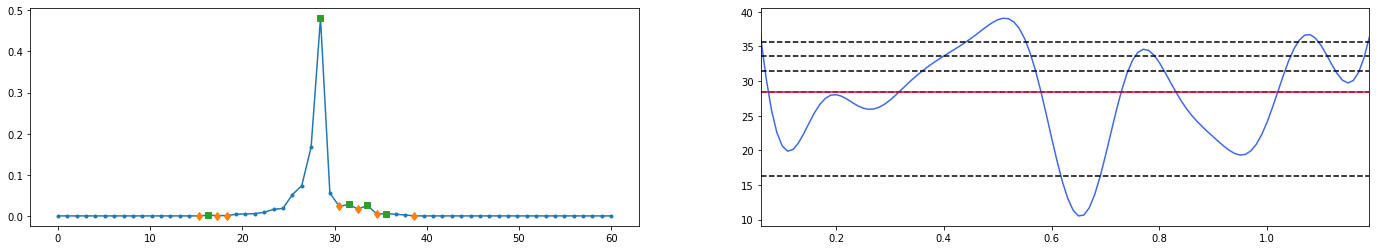

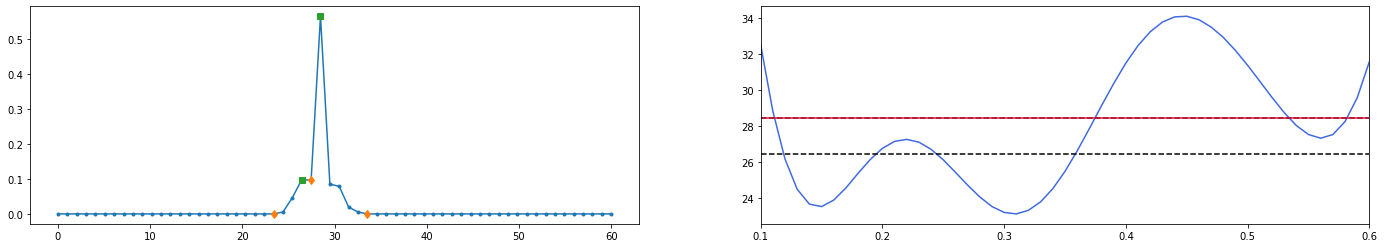

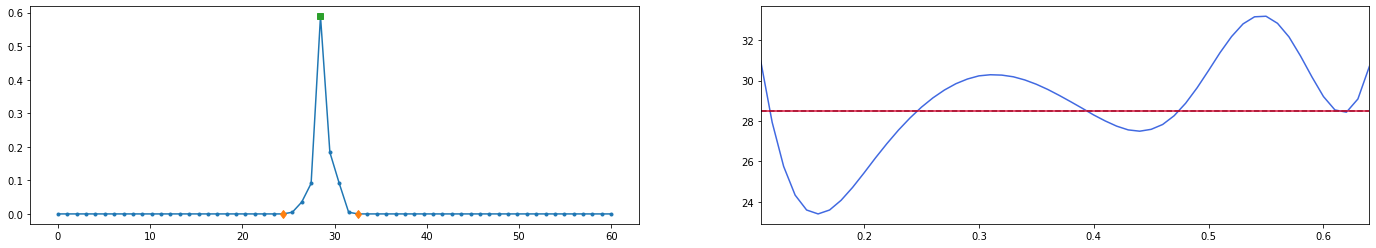

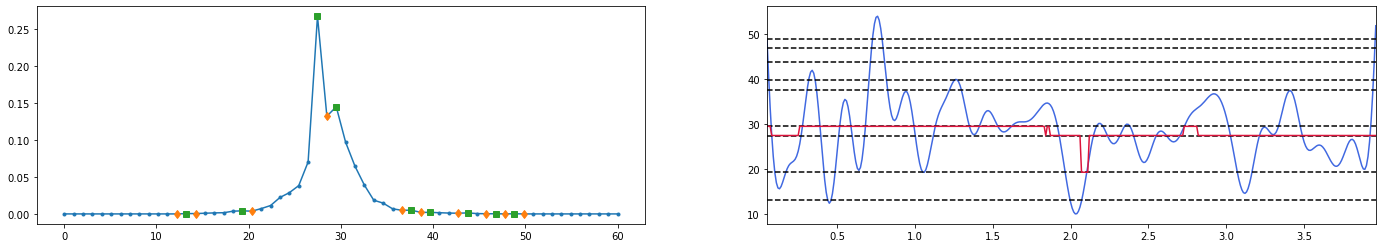

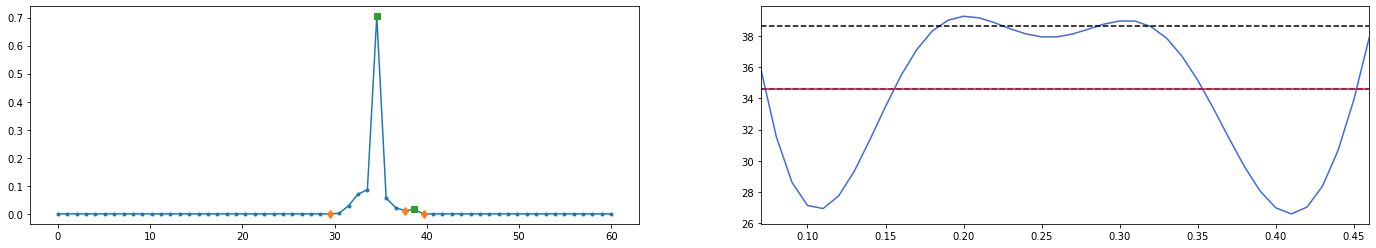

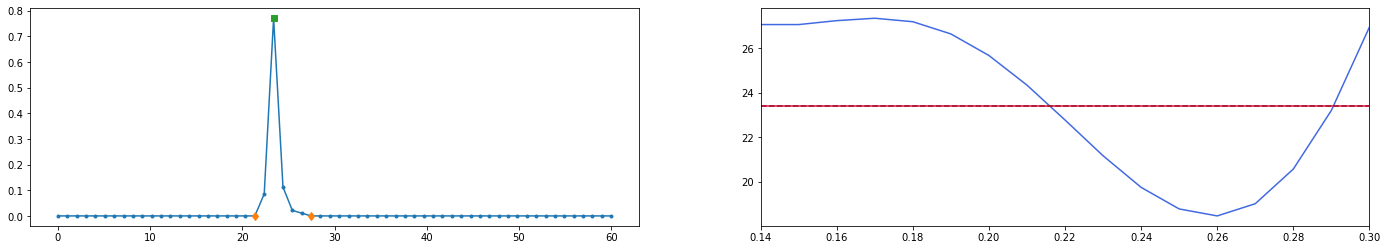

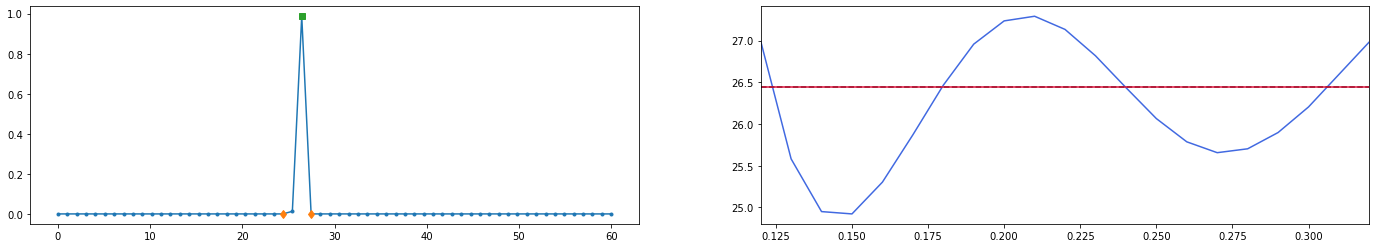

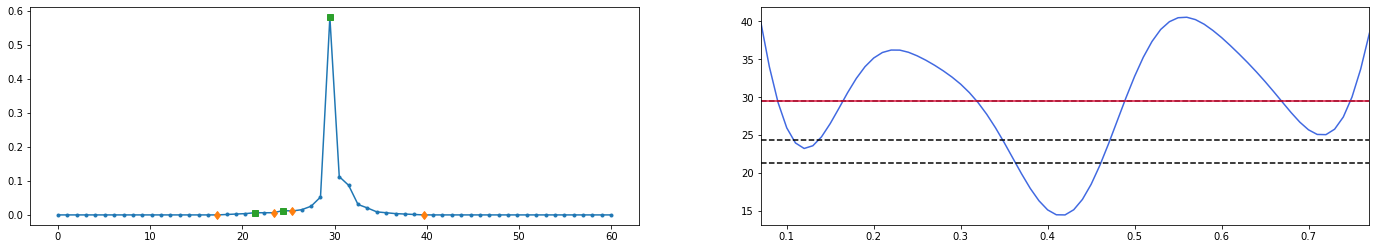

In [57]:
xlim = (0.0, 60.0)
bins = 60

for i in np.random.choice(len(cores), 10):
    # step detection
    core = cores[i]
    t = core[:,0]
    I = core[:,1]
    Is_l, ids_step_l = steps_detection_spectrum(I, ws=5, n_order=10)

    # plot
    H = []
    for k in range(len(Is_l)):
        h = np.histogram(Is_l[k], bins=bins, range=xlim)[0]
        H.append(h / np.sum(h))

    H = np.stack(H)
    mh = np.mean(H, axis=0)
    x = np.linspace(xlim[0], xlim[1], bins)
    ids_min, ids_max = tsp.signals.find_local_extrema(mh)
    ids_lvls = np.argmin(np.abs(Is_l[-1].reshape(-1,1) - x[ids_max].reshape(1,-1)), axis=1)
    
    # discretized
    ids_lvls = np.argmin(np.abs(np.expand_dims(np.stack(Is_l), 2) - x[ids_max].reshape(1,1,-1)), axis=2)
    ids_maj_lvls = np.array([np.argmax(np.bincount(ids)) for ids in ids_lvls.T])
    I_maj_lvls = x[ids_max][ids_maj_lvls]

    # plot
    plt.figure(figsize=(24,4))
    plt.subplot(121)
    plt.plot(x, mh, '.-')
    plt.plot(x[ids_min], mh[ids_min], 'd')
    plt.plot(x[ids_max], mh[ids_max], 's')

    # plot
    plt.subplot(122)
    plt.plot(t, I, color='royalblue')
    #plt.plot(t, Is_l[-8], color='springgreen')
    for k in ids_max:
        plt.plot([t[0],t[-1]], [x[k],x[k]], '--', color='black')
    plt.plot(t, I_maj_lvls.T, color='crimson')
    plt.xlim(t[0], t[-1])
    plt.show()

In [62]:
# levels analysis for all events
levels = []
H_l = []
for i in tqdm(range(len(cores))):
    # step detection
    core = cores[i]
    t = core[:,0]
    I = core[:,1]
    Is_l, ids_step_l = steps_detection_spectrum(I, ws=3, n_order=5)

    # plot
    H = []
    for k in range(len(Is_l)):
        h = np.histogram(Is_l[k], bins=120, range=(0.0,60.0))[0]
        H.append(h / np.sum(h))

    # aggregate distributions and find peaks
    H = np.stack(H)
    mh = np.mean(H, axis=0)
    x = np.linspace(0.0, 60.0, 120)
    ids_min, ids_max = tsp.signals.find_local_extrema(mh)
    
    # store results
    levels.append(x[ids_max])
    H_l.append(H)

100%|██████████| 28562/28562 [03:04<00:00, 154.84it/s]


levels: [28.7394958  52.94117647 54.95798319 55.96638655 57.98319328]


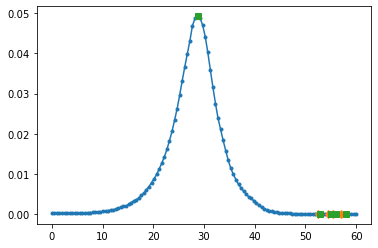

In [63]:
# pack and filter nan
H_all = np.stack(H_l)
H_all = H_all[~np.any(np.any(np.isnan(H_all), axis=2), axis=1)]
H_all.shape

# mean histogram
mh = np.mean(np.mean(H_all, axis=0), axis=0)
ids_min, ids_max = tsp.signals.find_local_extrema(mh)

# debug print
print("levels:", x[ids_max])

# plot
plt.figure()
plt.plot(x, mh, '.-')
plt.plot(x[ids_min], mh[ids_min], 'd')
plt.plot(x[ids_max], mh[ids_max], 's')
plt.show()